<a href="https://colab.research.google.com/github/ericodle/GINSA/blob/main/RUN_GINSA_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests
!pip install wget
!pip install biopython

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=d24dffbc7b14265ee19eee810b3da3521efe2e02204e639a758d41bf013b2ae6
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.3 MB/s eta 0:00:00


In [2]:
import urllib.request
import json
import urllib.parse
import os
import csv
import requests
import pandas as pd
import wget
import gzip
import shutil
from Bio import SeqIO
import matplotlib.pyplot as plt

In [8]:
###############################################################################################################################

def search_species_occurrences(species_name, limit=1000):
    base_url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "scientificName": species_name,
        "limit": limit,
    }

    occurrence_ids = []

    offset = 0
    while True:
        params["offset"] = offset
        encoded_params = urllib.parse.urlencode(params)
        full_url = f"{base_url}?{encoded_params}"

        with urllib.request.urlopen(full_url) as response:
            data = json.loads(response.read())

            if "results" in data:
                occurrence_ids.extend([occurrence["key"] for occurrence in data["results"]])
                if len(data["results"]) < limit:
                    break  # Reached the end of results
                else:
                    offset += limit
            else:
                break

    return occurrence_ids

###############################################################################################################################

def create_folders(occurrence_ids, proj_dir):
    if not os.path.exists(proj_dir):
        os.makedirs(proj_dir)

    for occurrence_id in occurrence_ids:
        folder_path = os.path.join(proj_dir, str(occurrence_id))
        os.makedirs(folder_path, exist_ok=True)

###############################################################################################################################

def generate_csv(occurrence_ids, proj_dir):
    with open(proj_dir + '/occurrences.csv', mode='w', newline='', encoding='utf-8') as csv_file:
        fieldnames = ['occurrence_id', 'country', 'latitude', 'longitude', 'prefix_text']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

        writer.writeheader()

        for occurrence_id in occurrence_ids:
            url = f"https://api.gbif.org/v1/occurrence/{occurrence_id}"
            response = requests.get(url)

            if response.status_code == 200:
                try:
                    data = response.json()
                    long_id = data.get("occurrenceID")
                    if long_id:
                        country = data.get("countryCode")
                        latitude = data.get("decimalLatitude")
                        longitude = data.get("decimalLongitude")
                        underscore_index = long_id.find("_")
                        if underscore_index != -1:
                            prefix_text = long_id[:underscore_index]
                        else:
                            prefix_text = "N/A"
                        writer.writerow({
                            'occurrence_id': occurrence_id,
                            'country': country,
                            'latitude': latitude,
                            'longitude': longitude,
                            'prefix_text': prefix_text
                        })
                    else:
                        print(f"occurrenceID not found for occurrence ID {occurrence_id}. Skipping.")

                except ValueError:
                    print(f"Failed to parse JSON for occurrence {occurrence_id}.")
            else:
                print(f"Failed to fetch content for occurrence {occurrence_id}. Status code: {response.status_code}")

    print("CSV file created successfully.")
###############################################################################################################################

def process_directory(proj_dir):
    for root, dirs, files in os.walk(proj_dir):
        for file in files:
            if file.endswith(".gz"):
                gz_file_path = os.path.join(root, file)
                extract_path = os.path.splitext(gz_file_path)[0]

                with gzip.open(gz_file_path, 'rb') as f_in, open(extract_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)

                os.remove(gz_file_path)
                print(f"Extracted and deleted: {gz_file_path}")

###############################################################################################################################

def ssu_fasta_grab(csv_file, proj_dir):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Replace with your actual MGnify API endpoint
    api_base_url = "https://www.ebi.ac.uk/metagenomics/api/v1"

    # Iterate through the DataFrame and process each occurrence
    for prefix_text, occurrence_id in zip(df['prefix_text'], df['occurrence_id']):
        if pd.isna(prefix_text):  # Check if prefix_text is NaN
            print(f"MGnify link not found in occurrence metadata for ID {occurrence_id}.")
            continue  # Continue to the next iteration

        if "MGY" not in prefix_text.upper():  # Confirm prefix text points to EMBI MGnify
            print(f"MGnify link not found in occurrence metadata for ID {occurrence_id}.")
            continue  # Continue to the next iteration

        url = f"{api_base_url}/analyses/{prefix_text}/downloads"
        response = requests.get(url)
        data = response.json()

        print(f"Processing {prefix_text}...")

        # Create a directory with the occurrence_id in the project directory
        subdir_path = os.path.join(proj_dir, str(occurrence_id))
        if not os.path.exists(subdir_path):
            os.makedirs(subdir_path)

        fasta_links = []

        for entry in data['data']:
            link_entry = entry['links']['self']
            if link_entry.endswith("SSU.fasta.gz"):
                fasta_links.append(link_entry)

        if fasta_links:
            print(f"Downloading {len(fasta_links)} file(s) for {prefix_text}...")
            for fasta_link in fasta_links:
                file_name = os.path.basename(fasta_link)
                file_path = os.path.join(subdir_path, file_name)
                wget.download(fasta_link, file_path)
            print(" Download complete.")
        else:
            print(f"No fasta files found for {prefix_text}. Saving 'no_fasta.txt'...")
            no_fasta_file = os.path.join(subdir_path, "no_fasta.txt")
            with open(no_fasta_file, "w") as f:
                f.write("No fasta files found.")

###############################################################################################################################

def mapseq_grab(csv_file, proj_dir):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Replace with your actual MGnify API endpoint
    api_base_url = "https://www.ebi.ac.uk/metagenomics/api/v1"

    # Iterate through the DataFrame and process each occurrence
    for prefix_text, occurrence_id in zip(df['prefix_text'], df['occurrence_id']):
        if pd.isna(prefix_text):  # Check if prefix_text is NaN
            print(f"MGnify link not found in occurrence metadata for ID {occurrence_id}.")
            continue  # Continue to the next iteration

        if "MGY" not in prefix_text.upper():  # Confirm prefix text points to EMBI MGnify
            print(f"MGnify link not found in occurrence metadata for ID {occurrence_id}.")
            continue  # Continue to the next iteration

        url = f"{api_base_url}/analyses/{prefix_text}/downloads"
        response = requests.get(url)
        data = response.json()

        print(f"Processing {prefix_text}...")

        # Create a directory with the occurrence_id in the project directory
        subdir_path = os.path.join(proj_dir, str(occurrence_id))
        if not os.path.exists(subdir_path):
            os.makedirs(subdir_path)

        mapseq_links = []


        # Check if 'data' key is present in the response dictionary
        if 'data' not in data:
            print("Error: 'data' key not present in the API response.")
            return

        # Loop through the data to find links ending with "MERGED_FASTQ_SSU_MAPSeq.mseq.gz"
        for entry in data['data']:
            link_entry = entry['links']['self']
            if link_entry.endswith("SSU_MAPSeq.mseq.gz"):
                mapseq_links.append(link_entry)


        if mapseq_links:
            print(f"Downloading {len(mapseq_links)} file(s) for {occurrence_id}...")
            for mapseq_link in mapseq_links:
                file_name = os.path.basename(mapseq_link)
                file_path = os.path.join(subdir_path, file_name)
                wget.download(mapseq_link, file_path)
            print("Download complete.")
        else:
            print(f"No MAPSeq files found for {occurrence_id}. Saving 'no_mapseq.txt'...")
            no_mapseq_file = os.path.join(subdir_path, "no_mapseq.txt")
            with open(no_mapseq_file, "w") as f:
                f.write("No MAPSeq files found.")


###############################################################################################################################

def find_target_in_mapseq(subdirectory, file_path, genus, species):

    truncated_strings = []  # List to store truncated strings

    try:
        with open(file_path, 'r') as file:
            content = file.readlines()

            for line in content:
                line = line.strip()
                if genus in line and species in line:
                    # Find the index of the search word in the line
                    word_index = line.index(species)

                    # Extract the preceding string
                    preceding_string = line[:word_index].strip()
                    # Truncate to only the text before the first space
                    truncated_string = preceding_string.split()[0]
                    truncated_strings.append(truncated_string)

        with open(subdirectory+"/truncated_strings.txt", 'w') as output_file:
            for item in truncated_strings:
                output_file.write("%s\n" % item)

    except FileNotFoundError:
        print("MAPSeq Search Error: The file does not exist or the path is incorrect.")

    return truncated_strings

###############################################################################################################################

def sift_fasta(fasta_file_path, truncated_strings_path):
    sifted_data = {}  # Dictionary to store truncated_strings and their corresponding DNA sequences

    if truncated_strings_path:
        with open(truncated_strings_path, 'r') as file:
            lines = file.readlines()
        lines = [line.strip() for line in lines]

# Parse the FASTA file and extract sequences
    with open(fasta_file_path, "rt") as fasta_file:
        records = SeqIO.parse(fasta_file, "fasta")
        for record in records:
            sequence_name = record.id
            sequence = str(record.seq)

# Search for sequence names in the truncated_strings list
            for truncated_string in lines:
                if truncated_string == sequence_name:
                    sifted_data.setdefault(truncated_string, []).append(sequence)
                    break

    return sifted_data
###############################################################################################################################

def save_sifted_data_to_csv(sifted_data, output_file):
    with open(output_file, "w", newline="") as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(["Truncated String", "Sequences"])

        for truncated_string, sequences in sifted_data.items():
            csv_writer.writerow([truncated_string, "\n".join(sequences)])

###############################################################################################################################

def analyze_subdir_mapseq(proj_dir, genus, species):
    # Iterate through subdirectories in proj_dir
    for subdirectory in os.listdir(proj_dir):
        subdir_path = os.path.join(proj_dir, subdirectory)

        # Skip if not a directory
        if not os.path.isdir(subdir_path):
            print(f"Skipping non-directory: {subdirectory}")
            continue

        print(f"Analyzing subdirectory {subdirectory} for MAPSeq files")

        # Check for required files and txt file
        for file_name in os.listdir(subdir_path):
            if file_name.endswith("SSU_MAPSeq.mseq"):
                print(file_name)

                find_target_in_mapseq(subdir_path, subdir_path+"/"+file_name, genus, species)
                print("Truncated strings obtained from MAPSeq file.")

###############################################################################################################################


def analyze_subdir_fasta(proj_dir):
    # Iterate through subdirectories in proj_dir
    for subdirectory in os.listdir(proj_dir):
        subdir_path = os.path.join(proj_dir, subdirectory)

        print("subdirectory path:", subdir_path)

        # Skip if not a directory
        if not os.path.isdir(subdir_path):
            print(f"Skipping non-directory: {subdirectory}")
            continue

        print(f"Analyzing subdirectory {subdirectory} for FASTA files.")

        fasta_files = [file_name for file_name in os.listdir(subdir_path) if file_name.endswith("SSU.fasta")]

        # Check if any FASTA files are found in the subdirectory
        if fasta_files:
            # Iterate through FASTA files in the subdirectory
            for fasta_file in fasta_files:
                fasta_filepath = os.path.join(subdir_path, fasta_file)
                print("Found FASTA file:", fasta_filepath)

                # Construct the path for the truncated strings file
                truncated_strings_filepath = os.path.join(subdir_path, "truncated_strings.txt")

                # Perform analysis using sift_fasta and save_sifted_data_to_csv functions
                sifted_data = sift_fasta(fasta_filepath, truncated_strings_filepath)

                # Create a new CSV filename based on the original FASTA filename
                csv_filename = os.path.splitext(fasta_file)[0] + "_extracted_sequences.csv"

                # Save the sifted data to the new CSV file
                save_sifted_data_to_csv(sifted_data, os.path.join(subdir_path, csv_filename))

            print("Extraction and CSV creation complete for all FASTA files.")
        else:
            print("No FASTA files found in the subdirectory.")

###############################################################################################################################


def check_for_csv(subdirectory_path):
    csv_files = [file for file in os.listdir(subdirectory_path) if file.endswith('.csv')]
    return len(csv_files) > 0

##################################################################################################################################

def check_dir(root_directory):
    subdirectories = [d for d in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, d))]

    presence_data = []
    for subdir in subdirectories:
        has_csv = check_for_csv(os.path.join(root_directory, subdir))
        presence_data.append(has_csv)

    num_have_csv = presence_data.count(True)
    num_not_have_csv = presence_data.count(False)

    plt.figure(figsize=(6, 6))
    plt.bar(['Sequences Found', 'Sequences Not Found'], [num_have_csv, num_not_have_csv], color=['green', 'red'])
    #plt.xlabel('Project Sub-Folders')
    plt.ylabel('Number of Sub-folders')
    plt.title('Sub-folders Containing Sequences')
    plt.tight_layout()
    plt.savefig(root_directory + "/sifting_results")

##################################################################################################################################

def combine_csv_files(root_directory):
    subdirectories = [d for d in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, d))]

    combined_sequences = {}

    for subdir in subdirectories:
        if check_for_csv(os.path.join(root_directory, subdir)):
            subdir_sequences = []
            for csv_file in os.listdir(os.path.join(root_directory, subdir)):
                if csv_file.endswith('.csv'):
                    csv_path = os.path.join(root_directory, subdir, csv_file)
                    csv_content = pd.read_csv(csv_path)
                    if 'Sequences' in csv_content.columns:
                        sequences_data = csv_content['Sequences']
                        subdir_sequences.extend(sequences_data)

            if subdir_sequences:
                combined_sequences[subdir] = subdir_sequences

    if combined_sequences:
        fasta_content = ""
        for subdir, sequences in combined_sequences.items():
            if len(sequences) == 1:
                fasta_content += f">{subdir}\n{sequences[0]}\n"
            else:
                for i, sequence in enumerate(sequences, start=1):
                    fasta_content += f">{subdir}_{i}\n{sequence}\n"

        fasta_path = os.path.join(root_directory, 'seq_master.fasta')
        with open(fasta_path, 'w') as fasta_file:
            fasta_file.write(fasta_content)
        print("Combined sequences saved as 'seq_master.fasta' in the root directory.")

        return fasta_path

    else:
        print("No sequences found in subdirectories.")

##################################################################################################################################

def seq_master_lengths(fasta_file, root_directory):
    # Check if the FASTA file exists
    if not os.path.exists(fasta_file):
        print(f"Error: The file '{fasta_file}' does not exist.")
        return

    # Read sequences from the FASTA file
    sequences = list(SeqIO.parse(fasta_file, "fasta"))

    # Get sequence names and lengths
    seq_names = [seq.id for seq in sequences]
    seq_lengths = [len(seq) for seq in sequences]

    # Create a bar plot to visualize sequence lengths
    plt.figure(figsize=(15, 9))
    plt.bar(seq_names, seq_lengths, color='blue')
    plt.xlabel('Sequence Names')
    plt.ylabel('Sequence Length')
    plt.title('Sequence Lengths from FASTA File')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(root_directory, "sequence_lengths.png"))

##################################################################################################################################

def analyze_nucleotide_freqs(fasta_file, root_directory):

    sequences = list(SeqIO.parse(fasta_file, "fasta"))

    total_sequence = "".join(str(seq_record.seq) for seq_record in sequences)

    # Calculate nucleotide frequencies for the entire fasta file
    nucleotide_freq = {
        'A': total_sequence.count('A'),
        'T': total_sequence.count('T'),
        'C': total_sequence.count('C'),
        'G': total_sequence.count('G')
    }

    # Define colors for each nucleotide
    colors = ['blue', 'orange', 'green', 'red']

    # Plot nucleotide frequencies with colored bars
    plt.figure(figsize=(8, 6))
    bars = plt.bar(nucleotide_freq.keys(), nucleotide_freq.values(), color=colors)
    plt.xlabel('Nucleotides')
    plt.ylabel('Frequency')
    plt.title('Overall Nucleotide Frequencies')
    plt.tight_layout()

    total_count = sum(nucleotide_freq.values())
    print("Overall Nucleotide Frequencies:")
    for nucleotide, count in nucleotide_freq.items():
        print(f"{nucleotide}: {count} ({(count / total_count) * 100:.2f}%)")
    plt.savefig(root_directory + "/nucleotide_frequencies")

##################################################################################################################################

In [4]:
def main():

    print("Welcome to the GbIf Next-gen Sequence Analyzer! (GINSA)")

    proj_dir = input("Enter the path to an empty folder for this project:")

    species_name = input("Enter your target genus and species (i.e. Lecudina longissima):")

    gen_sp = species_name.split()

    if len(gen_sp) == 2:
        genus = gen_sp[0]
        print("Genus: ", genus)
        species = gen_sp[1]
        print("Species: ", species)

    elif len(gen_sp) == 1:
        genus = gen_sp[0]
        print("Genus: ", genus)
        species = gen_sp[0]
        print("Only Genus provided. Search will be based on: ", species)

    elif len(gen_sp) > 2:
        print("Too many search terms.")

    else:
        print("No search taxon entered.")

    occurrence_ids = search_species_occurrences(species_name)

    num_occurrences = len(occurrence_ids)

    if num_occurrences > 0:
        print(f"Number of occurrences found: {num_occurrences}")

    else:
        print("No occurrences found for this taxon.")

    if num_occurrences > 300:
        print("There seem to be many ocurrences of this taxon in GBIF. Please ensure that you have sufficient storage.")

    create_folders(occurrence_ids, proj_dir)
    print("Subdirectory folders created")

    print("Gathering biogeography data on all the occurrences found in GBIF...")
    generate_csv(occurrence_ids, proj_dir)

    print("Occurrence metadata CSV created")
    csv_file = proj_dir+"/occurrences.csv"

    print("Grabbing FASTA and MAPSeq files from MGnify via GBIF...")
    ssu_fasta_grab(csv_file, proj_dir)
    mapseq_grab(csv_file, proj_dir)

    print("Unpacking compressed files...")
    process_directory(proj_dir)

    print("Searching MAPSeq files...")
    analyze_subdir_mapseq(proj_dir, genus, species)

    print("Searching FASTA files...")
    analyze_subdir_fasta(proj_dir)

    print("Sequence acquisition complete! Analyzing your sequences and saving them to a FASTA file.")

    print("Checking sub-folders for new sequences.")
    check_dir(proj_dir)

    print("Aggregaring sequences into a master csv file.")
    fasta_path = combine_csv_files(proj_dir)

    print("Generating a master FASTA file containing your new sequences.")
    seq_master_lengths(fasta_path, proj_dir)

    print("Analyzing the sequences in your master FASTA file.")
    analyze_nucleotide_freqs(fasta_path, proj_dir)

Welcome to the GbIf Next-gen Sequence Analyzer! (GINSA)
Enter the path to an empty folder for this project:/content/3
Enter your target genus and species (i.e. Lecudina longissima):Lecudina longissima
Genus:  Lecudina
Species:  longissima
Number of occurrences found: 26
Subdirectory folders created
Gathering biogeography data on all the occurrences found in GBIF...
CSV file created successfully.
Occurrence metadata CSV created
Grabbing FASTA and MAPSeq files from MGnify via GBIF...
Processing MGYA00285555...
 Download complete.
Processing MGYA00289445...
 Download complete.
Processing MGYA00285391...
 Download complete.
Processing MGYA00289215...
 Download complete.
Processing MGYA00184067...
 Download complete.
Processing MGYA00285084...
 Download complete.
Processing MGYA00285982...
 Download complete.
Processing MGYA00288790...
 Download complete.
Processing MGYA00290125...
 Download complete.
Processing MGYA00357000...
 Download complete.
Processing MGYA00206049...
 Download comple

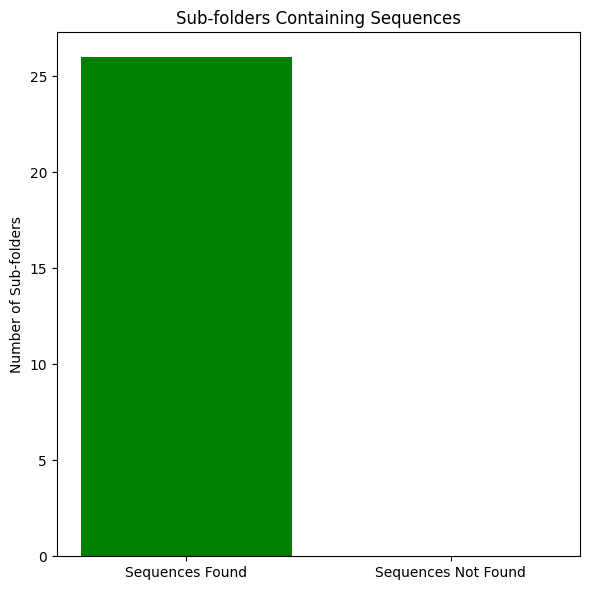

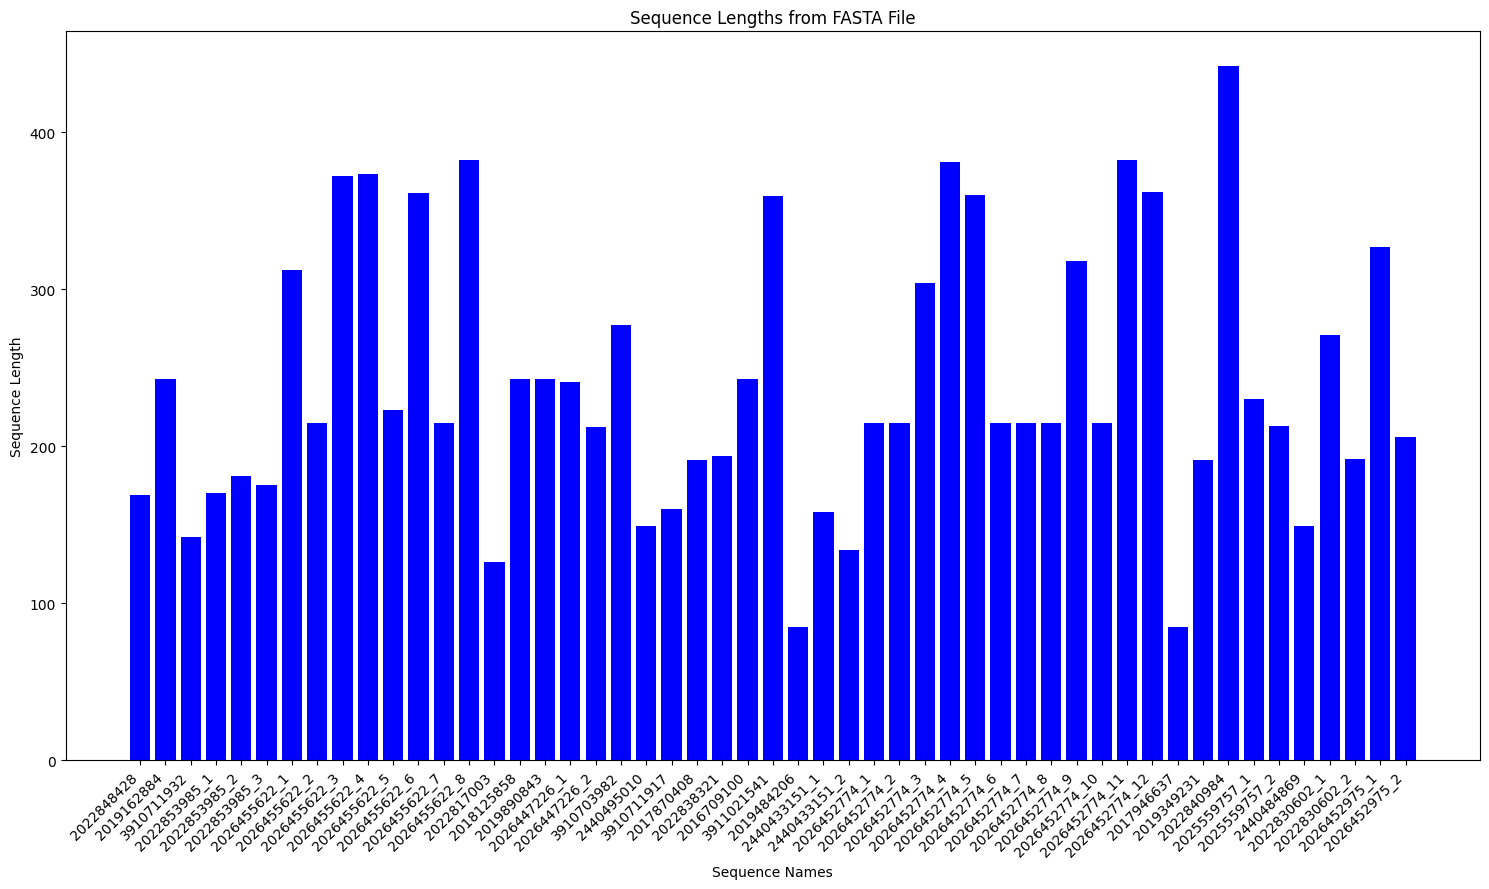

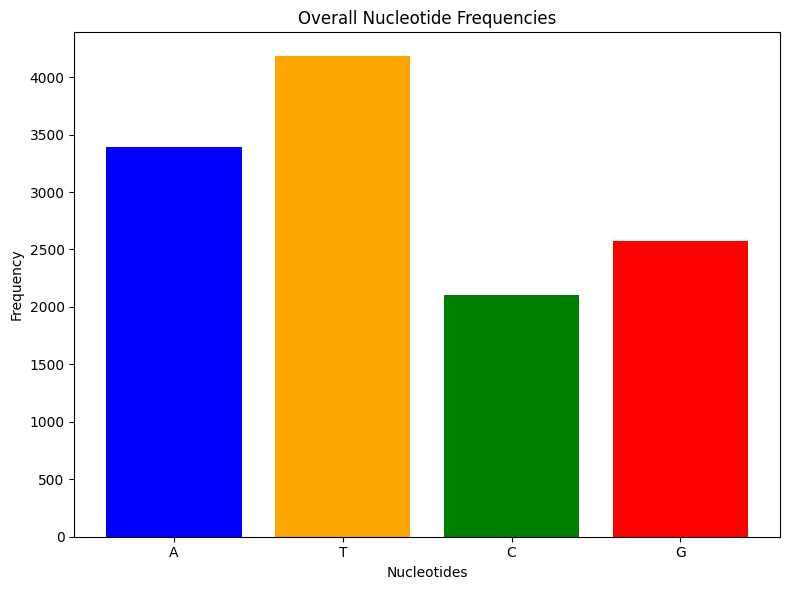

In [9]:
if __name__ == "__main__":
    main()